# Performance Analysis with Alphalens

## Imports & Settings

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os

# Get the current working directory
path = os.getcwd()

# Print the path
print("Current Path:", path)

# 이동할 디렉토리 경로
path = '/content/drive/MyDrive/Colab Notebooks'

# 디렉토리 변경
os.chdir(path)

Current Path: /content


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install alphalens

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.1 MB/s eta 0:00:00
  Created wheel for alphalens: filename=alphalens-0.4.0-py3-none-any.whl size=24027574 sha256=bf9bc5675c304a67f6607a924c1d9430e367ffe9081690f4254283af118b715d
  Stored in directory: /root/.cache/pip/wheels/4b/58/a6/6536c00c2d092cab6164cfa0ba4a4e714887f5d5afd40cb731
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39779 sha256=bd0f5e6c0abbbf1f249b0368dbb0a6ace0a329cf0d2a833b1c48b0dfae8ed7f1
  Stored in directory: /root/.cache/pip/wheels/0e/2e/f2/d6d2d9a1eb8fbbd9949bb5d4c00f753e3b74e5bd7ed10b1d36
Successfully built alphalens empyrical


In [12]:
from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [13]:
sns.set_style('whitegrid')

In [14]:
np.random.seed(42)
idx = pd.IndexSlice

In [15]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Alphalens Analysis

### Load predictions

In [24]:
DATA_STORE = Path(results_path / 'data.h5')

In [25]:
predictions = pd.read_hdf(results_path / 'predictions.h5', 'predictions')

In [26]:
factor = (predictions.mean(axis=1)
          .unstack('ticker')
          .resample('W-FRI', level='date')
          .last()
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('ticker').unique()

### Get trade prices

In [27]:
def get_trade_prices(tickers):
    prices = pd.read_hdf(DATA_STORE, 'stocks/prices/adjusted')
    prices.index.names = ['ticker', 'date']
    prices = prices.loc[idx[tickers, '2014':'2020'], 'open']
    return (prices
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .resample('W-FRI', level='date')
            .last()
            .tz_localize('UTC'))

In [28]:
trade_prices = get_trade_prices(tickers)

In [29]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2014-01-03 00:00:00+00:00 to 2020-01-03 00:00:00+00:00
Freq: W-FRI
Columns: 3825 entries, A to ZYXI
dtypes: float64(3825)
memory usage: 9.2 MB


In [30]:
trade_prices.to_hdf('tmp.h5', 'trade_prices')

### Generate tearsheet input

In [31]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(5, 10, 21)).sort_index()
factor_data.info()

Dropped 20.7% entries from factor data: 20.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 473074 entries, (Timestamp('2017-01-06 00:00:00+0000', tz='UTC', freq='C'), 'A') to (Timestamp('2019-08-09 00:00:00+0000', tz='UTC', freq='C'), 'ZYXI')
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   5D               473074 non-null  float64
 1   10D              473074 non-null  float64
 2   21D              473074 non-null  float64
 3   factor           473074 non-null  float32
 4   factor_quantile  473074 non-null  int64  
dtypes: float32(1), float64(3), int64(1)
memory usage: 18.2+ MB


### Create Tearsheet

In [34]:
factor_data

5D       10D       21D    factor  \
date                      asset                                           
2017-01-06 00:00:00+00:00 A      0.054572  0.110394  0.269546  0.036539   
                          AA     0.256153  0.130181  0.057319  0.038699   
                          AAIC   0.010101 -0.031650  0.016489  0.035030   
                          AAL    0.014205 -0.081204  0.081223  0.037824   
                          AAOI   0.499553  1.297406  2.352415  0.036411   
...                                   ...       ...       ...       ...   
2019-08-09 00:00:00+00:00 ZUO    0.064029 -0.010791  0.010791  0.012342   
                          ZVRA  -0.308652 -0.532346 -0.668745  0.008988   
                          ZWS    0.035196  0.006531  0.185777  0.005860   
                          ZYME   0.032494  0.203087  0.823721  0.008088   
                          ZYXI   0.084236  0.257521 -0.056558  0.007377   

                                 factor_quantile  
date                      asset                   
2017-01-06 00:00:00+00:00 A                    4  
                          AA                   5  
                          AAIC                 3  
                          AAL                  5  
                          AAOI                 4  
...                                          ...  
2019-08-09 00:00:00+00:00 ZUO                  5  
                          ZVRA                 5  
                          ZWS                  1  
                          ZYME                 4  
                          ZYXI                 3  

[473074 rows x 5 columns]

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.993799,0.039176,0.016164,0.043239,95470,20.180775
2,-0.002807,0.041624,0.021195,0.011071,105211,22.239861
3,-0.002070,0.042540,0.019164,0.010766,85571,18.088291
4,-0.001766,0.043846,0.021791,0.011406,92174,19.484055
5,-0.001566,0.082342,0.023740,0.011604,94648,20.007018


Returns Analysis


,5D,10D,21D
Ann. alpha,0.105,0.052,0.062
beta,0.188,0.210,0.107
Mean Period Wise Return Top Quantile (bps),18.667,13.626,9.793
Mean Period Wise Return Bottom Quantile (bps),-5.477,-10.173,-16.189
Mean Period Wise Spread (bps),24.144,23.502,25.851


Information Analysis


,5D,10D,21D
IC Mean,0.015,0.016,0.020
IC Std.,0.094,0.088,0.087
Risk-Adjusted IC,0.164,0.185,0.227
t-stat(IC),1.914,2.159,2.643
p-value(IC),0.058,0.033,0.009
IC Skew,0.102,0.524,0.571
IC Kurtosis,0.292,-0.181,-0.542


Turnover Analysis


,5D,10D,21D
Quantile 1 Mean Turnover,0.468,0.532,0.615
Quantile 2 Mean Turnover,0.595,0.640,0.696
Quantile 3 Mean Turnover,0.689,0.721,0.764
Quantile 4 Mean Turnover,0.626,0.661,0.708
Quantile 5 Mean Turnover,0.499,0.555,0.630


,5D,10D,21D
Mean Factor Rank Autocorrelation,0.543,0.461,0.348


<Figure size 640x480 with 0 Axes>

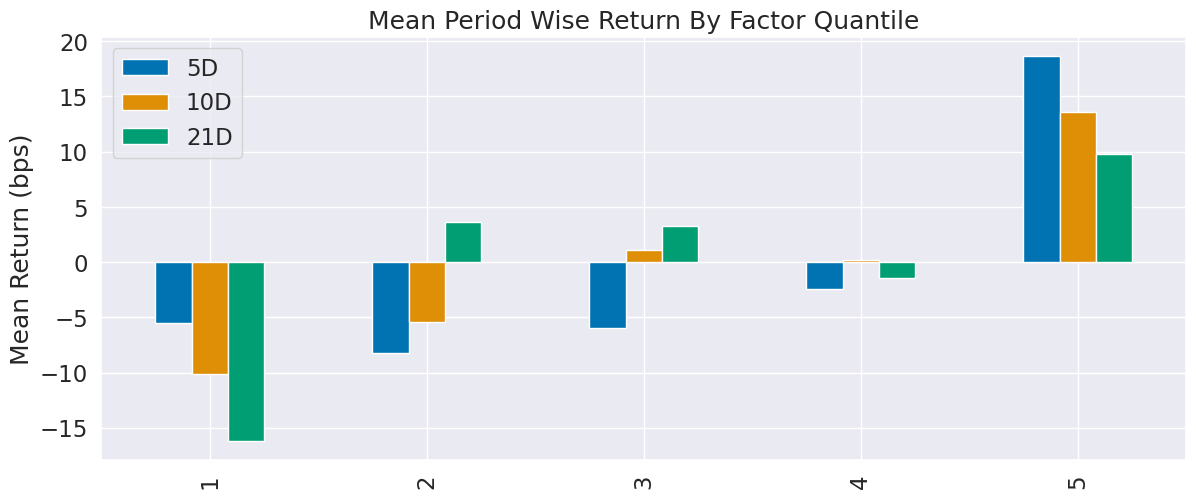

In [32]:
create_summary_tear_sheet(factor_data)

In [35]:
!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 65.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.993799,0.039176,0.016164,0.043239,95470,20.180775
2,-0.002807,0.041624,0.021195,0.011071,105211,22.239861
3,-0.002070,0.042540,0.019164,0.010766,85571,18.088291
4,-0.001766,0.043846,0.021791,0.011406,92174,19.484055
5,-0.001566,0.082342,0.023740,0.011604,94648,20.007018


Returns Analysis


,5D,10D,21D
Ann. alpha,0.105,0.052,0.062
beta,0.188,0.210,0.107
Mean Period Wise Return Top Quantile (bps),18.667,13.626,9.793
Mean Period Wise Return Bottom Quantile (bps),-5.477,-10.173,-16.189
Mean Period Wise Spread (bps),24.144,23.502,25.851


<Figure size 640x480 with 0 Axes>

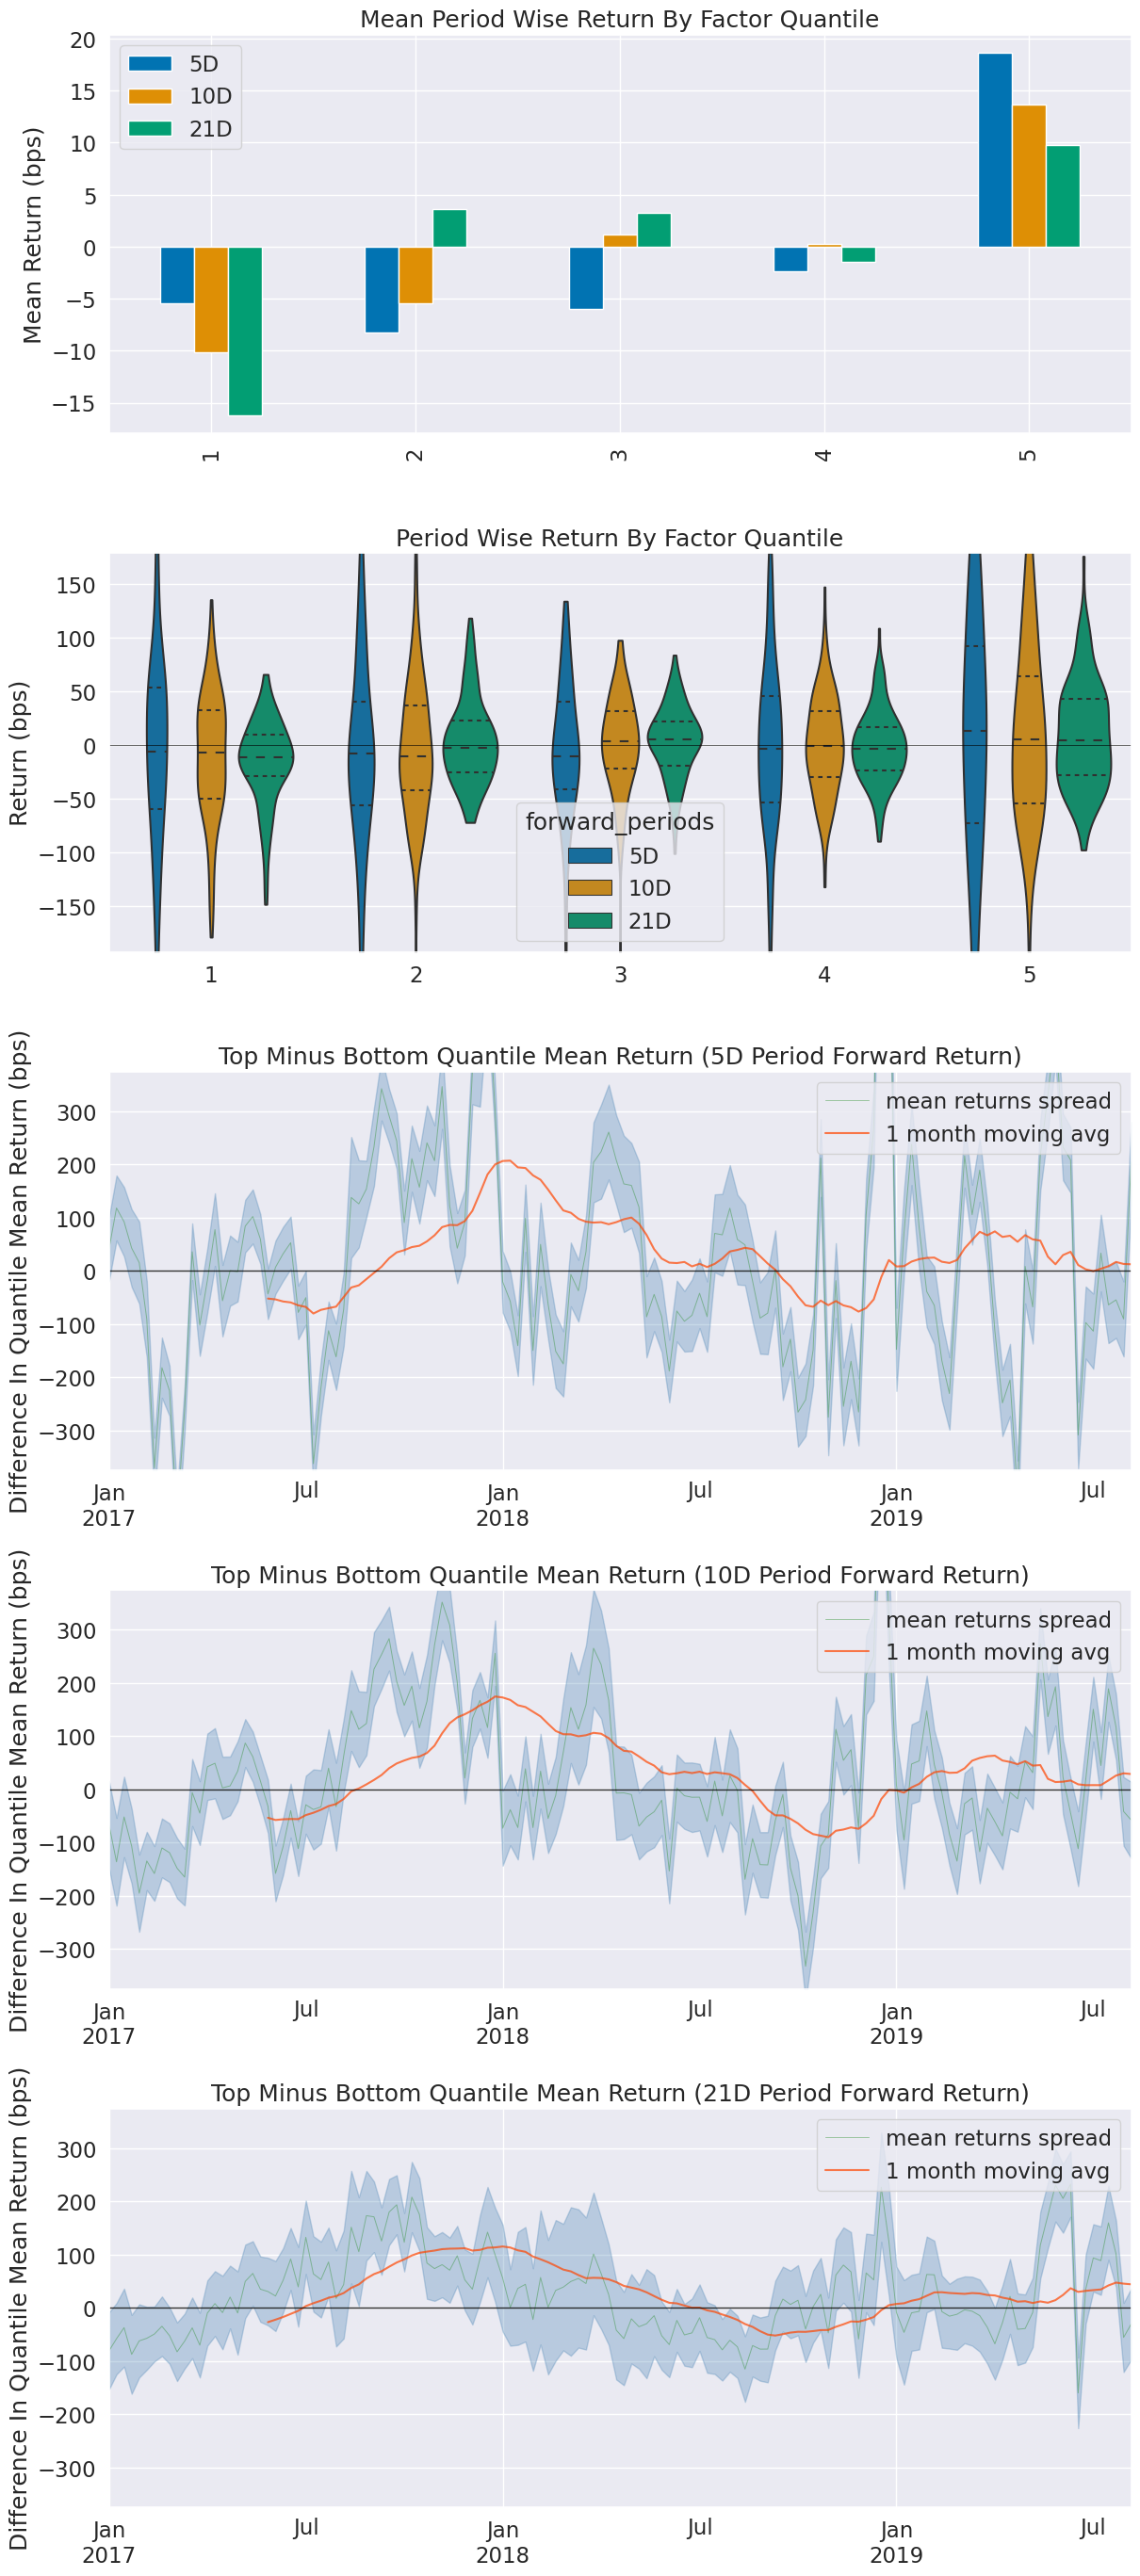

Information Analysis


,5D,10D,21D
IC Mean,0.015,0.016,0.020
IC Std.,0.094,0.088,0.087
Risk-Adjusted IC,0.164,0.185,0.227
t-stat(IC),1.914,2.159,2.643
p-value(IC),0.058,0.033,0.009
IC Skew,0.102,0.524,0.571
IC Kurtosis,0.292,-0.181,-0.542


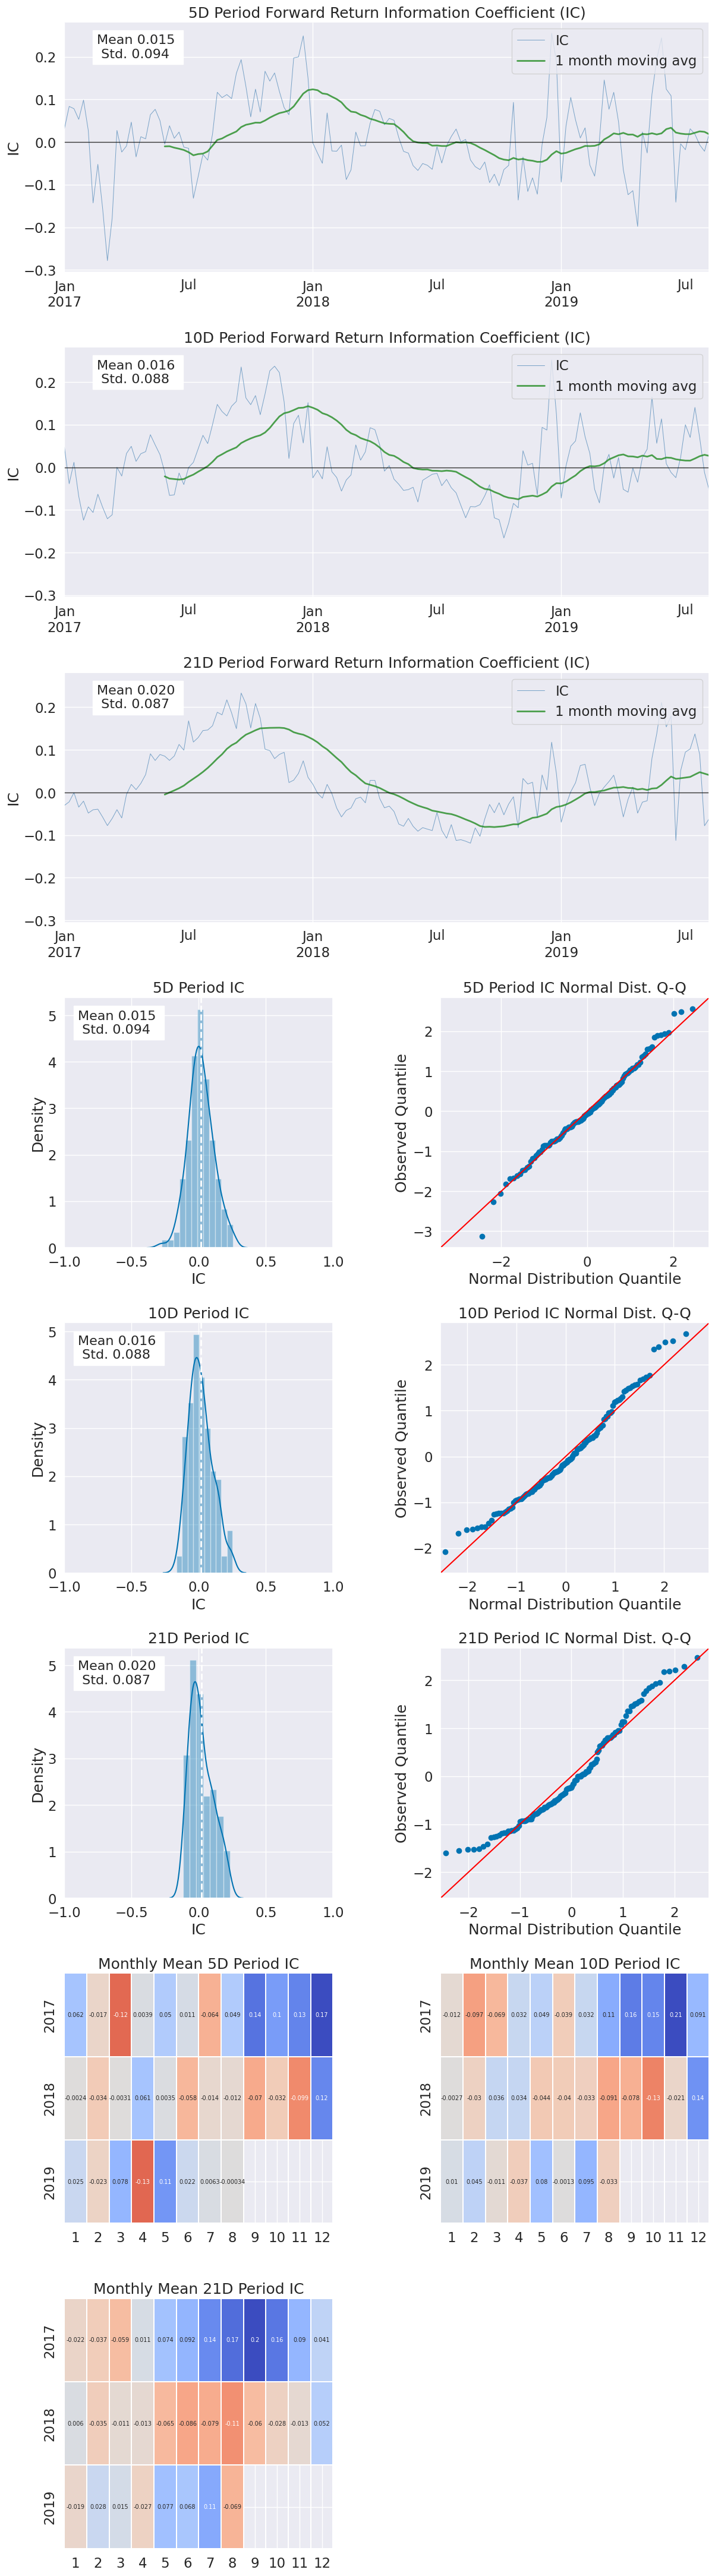

AttributeError: ignored

In [36]:
create_full_tear_sheet(factor_data)